In [1]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import random
import re
from plotly.subplots import make_subplots

In [2]:
### --- HELPER FUNCTIONS --- ###
def dbquery_find_list(search_list: list,
                      db_column: str,
                      db_table: str,
                      db_file: str) -> pd.DataFrame:
    query = f"SELECT * FROM {db_table} WHERE {db_column} IN ({','.join(['?']*len(search_list))}) ORDER BY {db_column} ASC"
    conn = sqlite3.connect(db_file)
    df = pd.read_sql(query, conn, params=search_list)
    conn.close()
    return df

In [5]:
### --- ALLOCATE DATA --- ###
db_file = '../data/mpibr_synprot.db'
query_list = ['Dlg4','Gad1', 'Gad2', 
               'Shank1', 'Slc17a7', 'Slc32a1', 
               'Slc6a3', 'Th', 'Camk2a']
df_info = dbquery_find_list(query_list, 'gene', 'info', db_file)
df_enriched = dbquery_find_list(df_info['protein'].to_list(), 'protein', 'enriched', db_file)
df_expressed = dbquery_find_list(df_info['protein'].to_list(), 'protein', 'expressed', db_file)

0 Camk2a
1 Dlg4
2 Gad1
3 Gad2
4 Shank1
5 Slc17a7
6 Slc32a1
7 Slc6a3
8 Th
['Camk2a', 'Dlg4', 'Gad1', 'Gad2', 'Shank1', 'Slc17a7', 'Slc32a1', 'Slc6a3', 'Th']


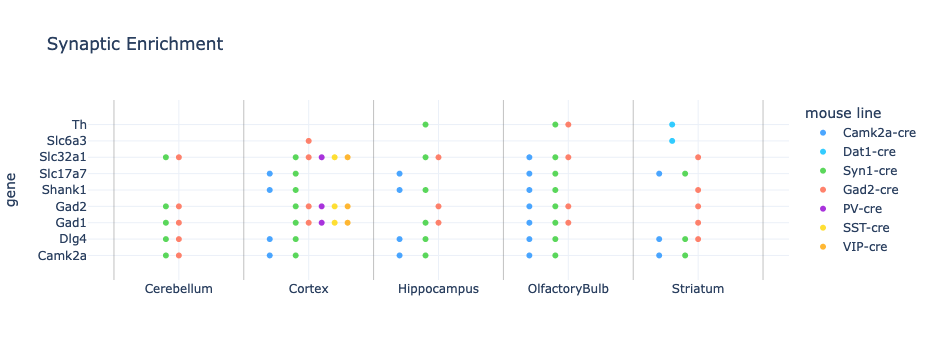

In [8]:
### --- PLOT ENRICHMENT --- ###
df = df_enriched.set_index('protein')

list_brain = []
list_mouse = []
for key in df.columns:
    brain, mouse = str.split(key, sep='.')
    if mouse != "Unsorted":
        mouse = mouse + "-cre"
    list_brain.append(brain)
    list_mouse.append(mouse)
#list_unq_brain = sorted(set(list_brain))
#list_unq_mouse = sorted(set(list_mouse), reverse=True)
list_unq_brain = ['Cerebellum', 'Cortex', 'Hippocampus', 'OlfactoryBulb', 'Striatum']
list_unq_mouse = ['Camk2a-cre', 'Dat1-cre', 'Syn1-cre', 'Gad2-cre', 'PV-cre', 'SST-cre', 'VIP-cre']

value_x_step = 0.1
value_x_min = -0.3

label_x = list_unq_brain
label_y = []
label_gene = []
label_mouse = []
label_brain = []
value_x = []
value_y = []
for value_y_tick, row_info in df_info.iterrows():
    label_y.append(row_info['gene'])
    print(value_y_tick, row_info['gene'])
    row_enriched = df.loc[row_info['protein']]
    for key, value in row_enriched.items():
        if value == 1:
            brain, mouse = str.split(key, sep='.')
            if mouse != "Unsorted":
                mouse = mouse + "-cre"
            value_x_shift = list_unq_mouse.index(mouse)
            value_x_tick = list_unq_brain.index(brain) + 1
            value_x_point = value_x_tick + (value_x_min + value_x_step * value_x_shift)
            value_x.append(value_x_point)
            value_y.append(value_y_tick + 1)
            label_mouse.append(mouse)
            label_gene.append(row_info['gene'])
            label_brain.append(brain)

df = pd.DataFrame({'x': value_x, 'gene': value_y, 'mouse line': label_mouse, 'gene': label_gene, 'region': label_brain})

color_map = {'Camk2a-cre': '#1E90FF', 
             'Dat1-cre': '#00BFFF',
             'Syn1-cre': '#32CD32',
             'Gad2-cre': '#FF6347',
             'PV-cre': '#9400D3',
             'SST-cre': '#FFD700',
             'VIP-cre': '#FFA500'}

print(label_y)

fig = px.scatter(df, x='x', y='gene', color='mouse line', opacity=0.8,
                 title='Synaptic Enrichment',
                 category_orders={'mouse line': list_unq_mouse},
                 color_discrete_map=color_map,
                 template='plotly_white',
                 hover_name = 'gene',
                 hover_data={'region':True,'x':False,'mouse line':True, 'gene':False})

fig.update_layout(xaxis=dict(tickmode="array", tickvals=np.arange(0, len(label_x)) + 1,
                              ticktext=label_x),
                  yaxis=dict(tickmode="array", tickvals=np.arange(0, len(label_y)),
                              ticktext=label_y),
                  xaxis_range=[0.3, 5.7],
                  yaxis_range=[-1.5, len(label_y) + 0.5],
                  xaxis_title='',
                  yaxis_title='gene',
                 )

for vidx in range(len(label_x)+1):
    fig.add_vline(x=vidx + .5, line_color='grey', line_width=0.5)


fig.show()

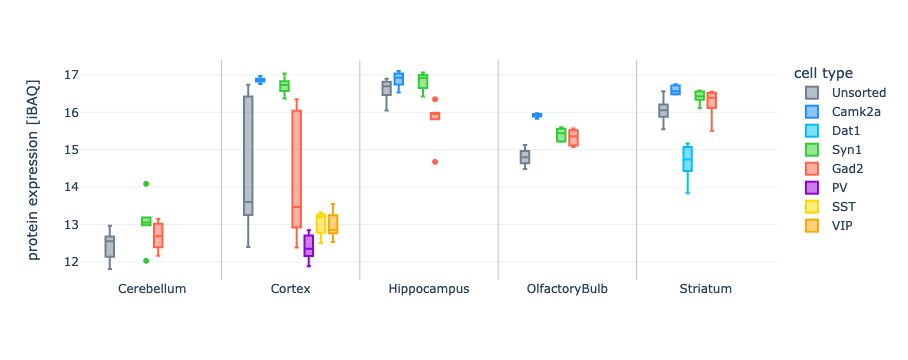

In [20]:
### --- PLOT EXPRESSION --- ###
search_key='Camk2a'
search_term = df_info['protein'].loc[df_info['gene'] == search_key].iloc[0]


df = df_expressed.set_index('protein')
index_row = random.randint(1, len(df)) - 1
record = df.loc[search_term]

list_regions = []
list_celltypes = []
list_values = []
for key, value in record.items():
    if value > 0:
        key = re.sub(r'\.\d+$', '', key)
        region, celltype = str.split(key, sep='.')
        list_regions.append(region)
        list_celltypes.append(celltype)
        list_values.append(value)
df = pd.DataFrame({'values': list_values, 'regions': list_regions, 'cell type': list_celltypes})


list_unq_regions = ['Cerebellum', 'Cortex', 'Hippocampus', 'OlfactoryBulb', 'Striatum']
list_unq_celltypes = ['Unsorted', 'Camk2a', 'Dat1', 'Syn1', 'Gad2', 'PV', 'SST', 'VIP']
color_map = {'Unsorted': '#708090', 
             'Camk2a': '#1E90FF', 
             'Dat1': '#00BFFF',
             'Syn1': '#32CD32',
             'Gad2': '#FF6347',
             'PV': '#9400D3',
             'SST': '#FFD700',
             'VIP': '#FFA500'}

fig = px.box(df, x='regions', y='values', 
             color='cell type',
             color_discrete_map=color_map,
             category_orders={'regions': list_unq_regions, 'cell type': list_unq_celltypes},
             template='plotly_white')

for vidx in range(len(list_unq_regions) - 1):
    fig.add_vline(x=vidx + .5, line_color='grey', line_width=0.5)

    
fig.update_layout(xaxis_title='',
                  yaxis_title='protein expression [iBAQ]')
    
# # Show the plot
fig.show()

